In [1]:
import PIL.Image as im
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [37]:
ROOT_DATA_DIR = '../../NICU_Data/DepthFrameFullPrec_PT/'
img = cv2.imread(ROOT_DATA_DIR + 'p8/nurse/patient8_138.png', -1)
# img = np.asarray(img)
# print(type(img))
# plt.imshow(img)
# print(img.min())
# print(img.max())
# print(img.mean())
# print(np.histogram(img, bins=30))
img_8bit = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))


def mouseEvent(action, x, y, flags, *userdata):
    global perspectivePoints, perspectiveSelectEnabled, stageOne_headPts, drawingHeadFinished, stageTwo_torsoPts, drawingTorsoFinished, currStage
    if action == cv2.EVENT_LBUTTONDBLCLK:
        # Perspective transform
            perspectivePoints.append((x, y))

windowName = "test"
while True:
    depth_frame = img_8bit
    depth_frame = depth_frame.astype('float64')
    depth_frame *= 255.0/depth_frame.max()
    depth_frame = depth_frame.astype('uint8')
    depth_frame = cv2.applyColorMap(depth_frame, cv2.COLORMAP_JET)
    cv2.imshow(windowName, depth_frame)

    # If user presses ESCAPE or clicks the close button, end    
    key = cv2.waitKey(1)
    if (key == 27) or (cv2.getWindowProperty(windowName, cv2.WND_PROP_VISIBLE) != 1):
        cv2.destroyAllWindows()
        break

In [3]:
depth_frame = img.copy()

slices = 20
sliceDepth = depth_frame.min()
sliceInc = (depth_frame.max() - sliceDepth) / slices
allSlices = []
for i in range(slices):
    depth_frame_mask = (depth_frame <= sliceDepth) * 1.0
    allSlices.append(depth_frame_mask)
    sliceDepth = sliceDepth + sliceInc
    # plt.imshow(depth_frame_mask)
    # plt.figure(i+1)

# plt.show()

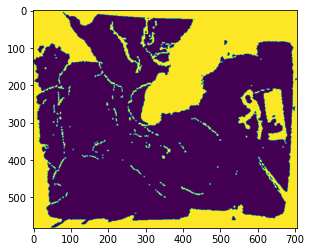

In [4]:
plt.imshow(allSlices[11])

In [5]:
allContours = []
allContours_area = []
for idx, slice in enumerate(allSlices):
    slice_frame = slice.astype(np.uint8)
    contours, hierarchy = cv2.findContours(slice_frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours_filteredArea = []
    for con in contours:
        area = cv2.contourArea(con)
        if area >= 10000:
            contours_filteredArea.append(con)

    allContours.append(contours)
    allContours_area.append(contours_filteredArea)

(414, 205)


(-0.5, 705.5, 581.5, -0.5)

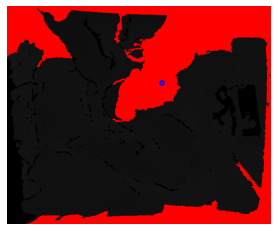

In [6]:
depth_frame_gray = cv2.cvtColor(depth_frame, cv2.COLOR_GRAY2BGR)
depth_frame_cons = cv2.drawContours(depth_frame_gray, allContours_area[11], 1, color=(255, 0, 0), thickness=-1)

M = cv2.moments(allContours_area[11][1])
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

print((cX, cY))

depth_frame_center_con = cv2.circle(depth_frame_cons, (cX, cY), 5, (0, 0, 255), 3)

plt.imshow(depth_frame_center_con)
plt.axis('off')

In [7]:
# Criteria check
def con_is_candidate(contour, img_height, img_width):
    contour = contour.reshape(contour.shape[0], contour.shape[2])
    if (contour[:, 0] == (img_width - 1)).any() or (contour[:, 0] == 0).any() or (contour[:, 1] == (img_height - 1)).any() or (contour[:, 1] == 0).any():
        # Get max distance from center of image for probability
        imgX = int(img_width/2)
        imgY = int(img_height/2)
        imgCenter = np.array((imgX, imgY))
        maxDist = np.linalg.norm(imgCenter)

        # Get contour center and calc distance from image center
        M = cv2.moments(contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        contourCenter = np.asarray((cX, cY))
        dist = np.linalg.norm(contourCenter - imgCenter)

        prob = (maxDist - dist) / maxDist
        return prob
    else:
        return 0

In [8]:
depth_frame

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)